In [1]:
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_path import path
from pathlib import Path
from PIL import Image
import rasterio

from random import randrange

import xarray
import xrspatial.multispectral as ms

In [2]:
DATA_DIR = Path.cwd().parent / "data/raw/train"
TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_LABELS = DATA_DIR / "train_labels"

BANDS = ["B02", "B03", "B04", "B08"]

In [3]:
train_meta = pd.read_csv(DATA_DIR / "train_metadata.csv")
train_meta.head()

chip_id  location              datetime                   cloudpath
0    adwp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwp
1    adwu  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwu
2    adwz  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwz
3    adxp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adxp
4    aeaj  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/aeaj

In [5]:
def add_paths(df, feature_dir, label_dir=None, bands=BANDS):
    """
    Given dataframe with a column for chip_id, returns a dataframe with a column
    added indicating the path to each band's TIF image as "{band}_path", eg "B02_path".
    A column is also added to the dataframe with paths to the label TIF, if the
    path to the labels directory is provided.
    """
    for band in bands:
        df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        #assert df[f"{band}_path"].path.exists().all()
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")
        #assert df["label_path"].path.exists().all()

    return df


train_meta = add_paths(train_meta, TRAIN_FEATURES, TRAIN_LABELS)
train_meta.head()

chip_id  location              datetime                   cloudpath  \
0    adwp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwp   
1    adwu  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwu   
2    adwz  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adwz   
3    adxp  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/adxp   
4    aeaj  Chifunfu  2020-04-29T08:20:47Z  az://./train_features/aeaj   

                                            B02_path  \
0  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...   
1  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...   
2  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...   
3  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...   
4  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...   

                                            B03_path  \
0  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...   
1  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...   
2  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...   
3  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...   
4  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...   

                                            B04_path  \
0  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...   
1  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...   
2  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...   
3  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...   
4  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...   

                                            B08_path  \
0  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...   
1  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...   
2  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...   
3  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...   
4  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...   

                                          label_path  
0  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...  
1  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...  
2  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...  
3  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...  
4  C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...

## Display the features and label

In [5]:
def load_features(image_index):
    image = np.zeros((512,512,4))
    for i, band in enumerate(['B02_path', 'B03_path', 'B04_path', 'B08_path']):
        with rasterio.open(train_meta[band][image_index]) as img:            
            image[:,:,i] = img.read(1)
    return image

In [6]:
def load_label(image_index):
    image = np.zeros((512,512,1))
    with rasterio.open(train_meta['label_path'][image_index]) as img:            
        image[:,:,0] = img.read(1)
    return image

In [7]:
def get_xarray(filepath):
    """Put images in xarray.DataArray format"""
    im_arr = np.array(Image.open(filepath))
    return xarray.DataArray(im_arr, dims=["y", "x"])


def true_color_img(image_index):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""
    blue = get_xarray(train_meta['B02_path'][image_index])
    green = get_xarray(train_meta['B03_path'][image_index])
    red = get_xarray(train_meta['B04_path'][image_index])

    return ms.true_color(r=red, g=green, b=blue)

In [8]:
def display_image(image_index):
    features = load_features(image_index)
    label = load_label(image_index)
    
    f, ax = plt.subplots(2, 3, figsize=(15, 15))    
    
    #visualize features
    ax[0][0].imshow(features[:,:,0])
    ax[0][0].set_title(f"Image {image_index} band 2")
    ax[0][1].imshow(features[:,:,1])
    ax[0][1].set_title(f"Image {image_index} band 3")
    ax[0][2].imshow(features[:,:,2])
    ax[0][2].set_title(f"Image {image_index} band 4")
    ax[1][0].imshow(features[:,:,3])
    ax[1][0].set_title(f"Image {image_index} band 8")
    
    #visualize label
    ax[1][1].imshow(label)
    ax[1][1].set_title("Label")
    
    #visualize true colored image
    ax[1][2].imshow(true_color_img(image_index))
    ax[1][2].set_title("True colored image")
    true_color_img
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=-0.45)
    
    plt.show()

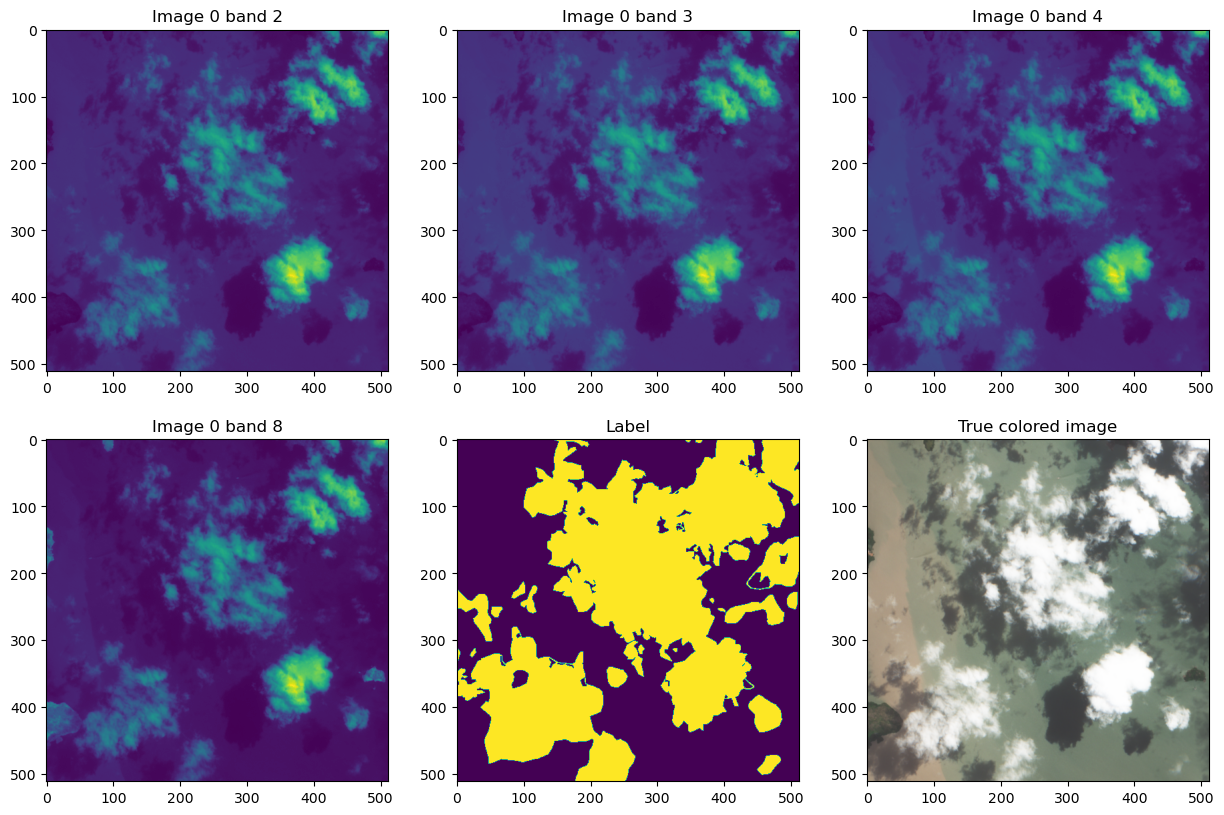

In [10]:
display_image(0)

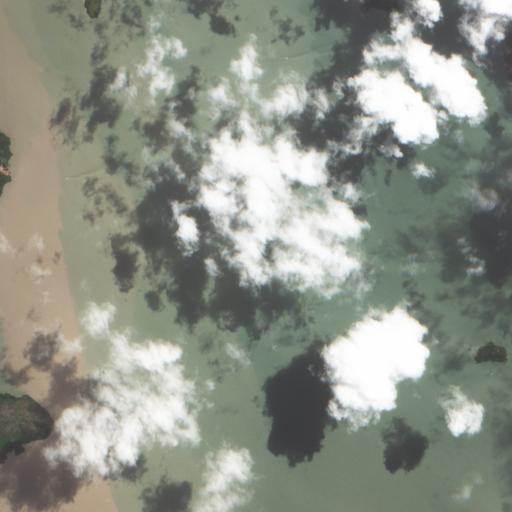

In [75]:
true_color_img(0)

## Make a patchwork of true colored images

In [105]:
def display_patchwork(size=10):
    f, ax = plt.subplots(size, size, figsize=(20, 20))
    
    for i in range(size):
        for j in range(size):
            ax[i][j].imshow(true_color_img(randrange(0, 11748)))
            ax[i][j].get_xaxis().set_visible(False)
            ax[i][j].get_yaxis().set_visible(False)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=-0.05, hspace=-0.45)
    plt.savefig('patchwork.png')
    plt.show()

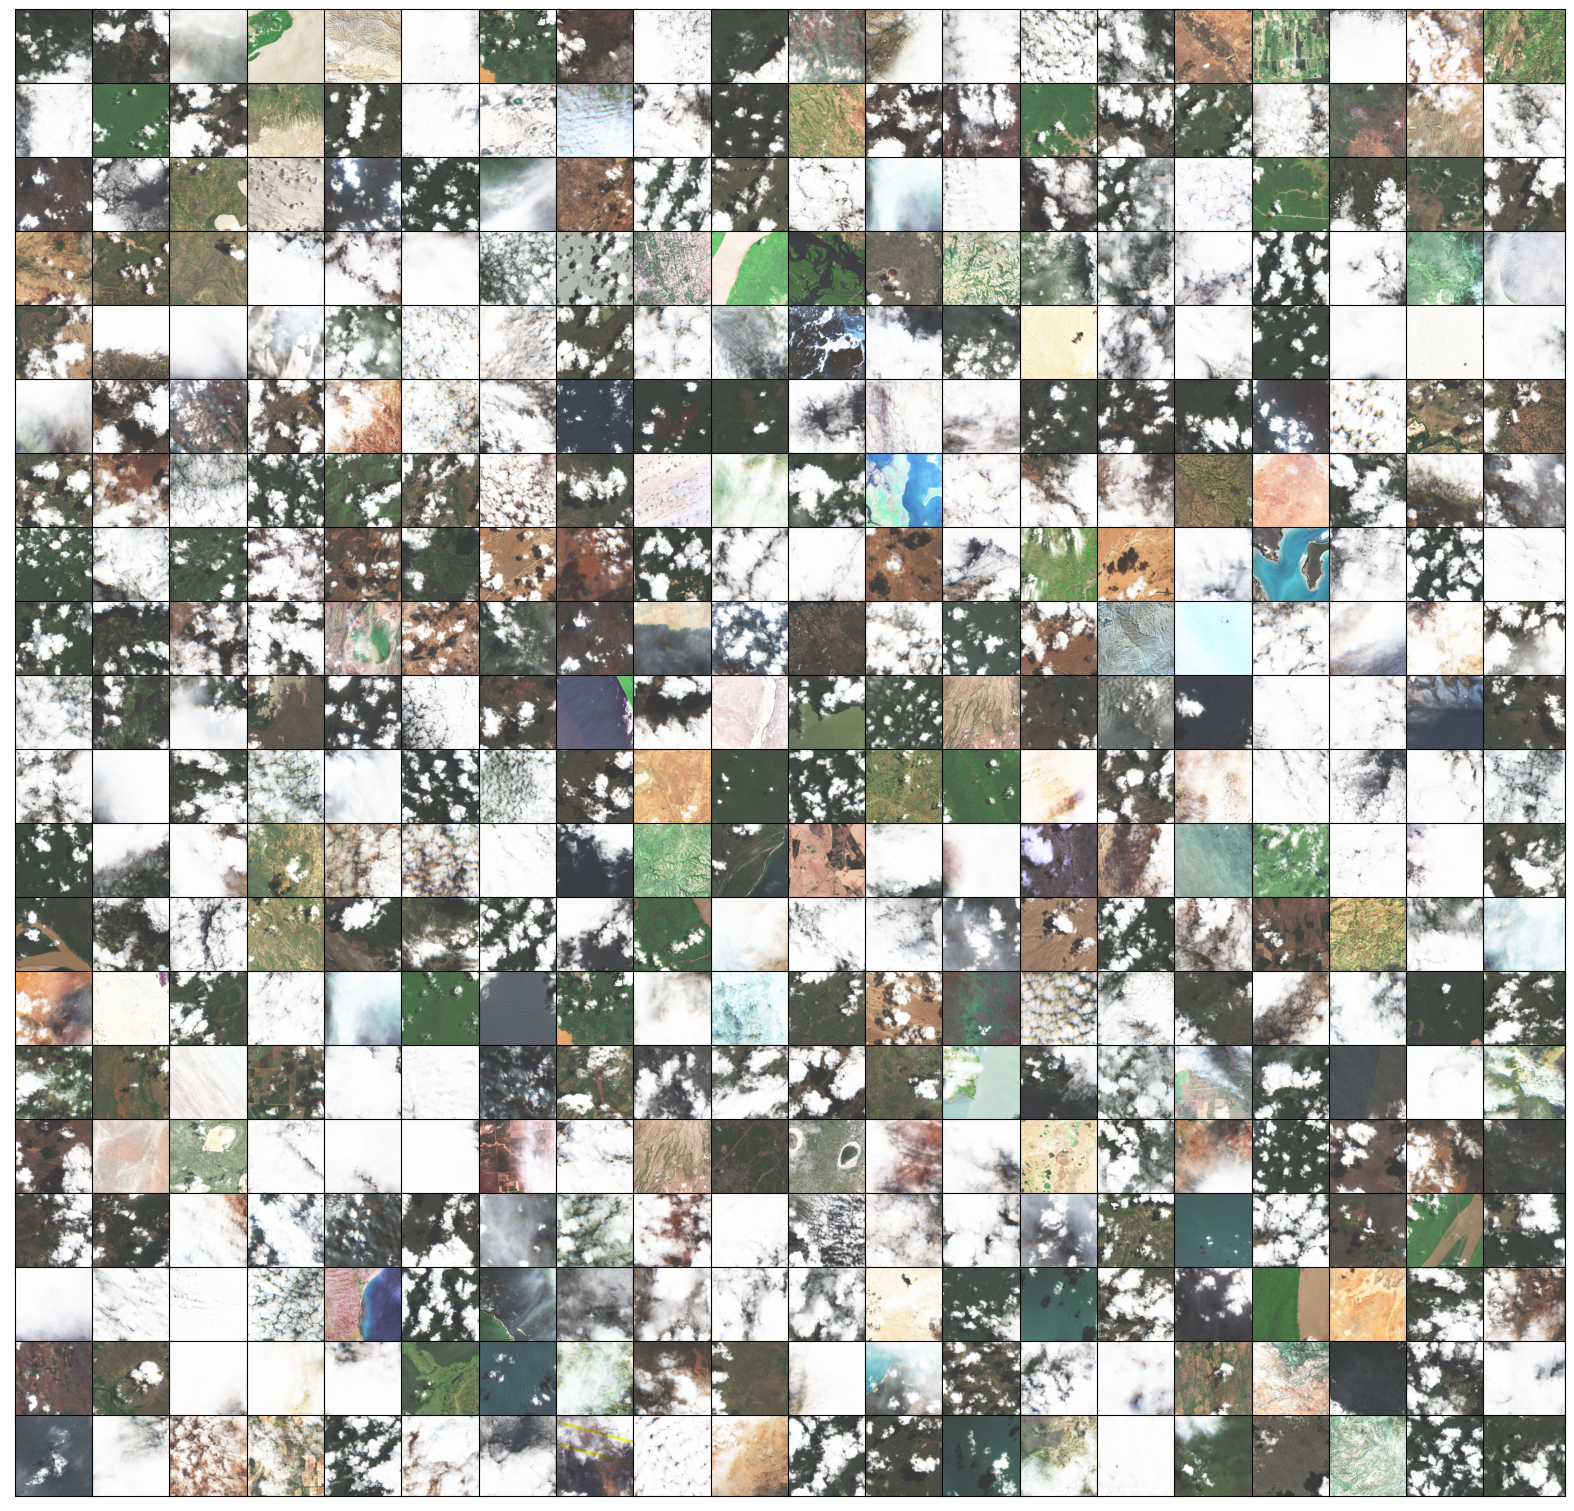

In [106]:
display_patchwork(20)